In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as path_effects
from statannotations.Annotator import Annotator
from scipy import stats
import matplotlib.patches as mpatches
import os
from itertools import zip_longest

In [2]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', labelsize=15) 
plt.rcParams['legend.title_fontsize'] = 15

# Load and clean data (DR)

In [ ]:
#load csv
os.chdir('/data/chamal/projects/mila/2021_fMRI_dev/part2_phgy_fmri_project/5_analysis/stats_and_mediation/mediation_path_effectSize_csvs/')
dr_phgy_df = pd.read_csv('../../DR_analysis-to_extract_network_detectability/final_outputs/master_DR_and_phgy_variableWindow_sparse.csv')

#add the fisherz transformed network detectability from R
fisherz_ND = pd.read_csv('./master_DR_and_phgy_variableWindow_sparse_fisherzND.csv')['Average.correlation.to.network.fisherz']
dr_phgy_df['Network detectability'] = fisherz_ND

#extract indices at 1.5% iso
indices_high_iso = dr_phgy_df[dr_phgy_df['Iso percent'] == 1.5].index

#rename certain columns
df_full_renamed = dr_phgy_df.rename(columns = {'actual_ses_order': 'session order (collinear with age)',
                                                'Iso percent': 'isoflurane (%)',
                                                'dex_conc': 'dexmedetomidine (mg/kg/h)',
                                                'age_days' : 'age (days)',
                                                'Network detectability' : 'Network detectability \n (FisherZ transformed)'})
#drop the windows with very high iso 1.5%
df_full_renamed = df_full_renamed.drop(indices_high_iso, errors = 'ignore')                                    

In [4]:
effects_df_nd_strain_sex = pd.read_csv(os.path.abspath('./pathc_effects_nd_strain_sex.csv'))
effects_df_nd_iso = pd.read_csv(os.path.abspath('./pathc_effects_nd_iso.csv')).rename(columns={'isoflurane_percent': 'isoflurane (%)', 'actual_ses_order': 'session order (collinear with age)'})
effects_df_nd_ses = pd.read_csv(os.path.abspath('./pathc_effects_nd_ses.csv')).rename(columns={'actual_ses_order': 'session order (collinear with age)'})
effects_df_nd_dex = pd.read_csv(os.path.abspath('./pathc_effects_nd_dex.csv')).rename(columns = {'dex_conc': 'dexmedetomidine (mg/kg/h)'})
effects_df_nd_time = pd.read_csv(os.path.abspath('./pathc_effects_nd_time.csv')).rename(columns = {'Time.after.isoflurane.change': 'Time after isoflurane change'})

## Plot scatterplots

In [5]:
def custom_pointplot(x_values, y_values, ax=None, error_sizes=None, error_upper=None, error_lower=None, xlabel = None, figsize = (6,5) , palette = 'blue', ylims = None,
                     continuous = False, orient = 'horizontal', **kwargs):
    plt.figure(figsize=figsize)
    if ax is None:
        ax = plt.gca()

    if continuous == False:

        # Determine unique x-values and their corresponding indices
        unique_x_values = sorted(set(x_values))
        x_indices = np.arange(len(x_values))

        # Map original x-values to their corresponding indices
        x_indices_map = {val: i for i, val in enumerate(unique_x_values)}
        mapped_x_values = [x_indices_map[val] for val in x_values]

        if orient == 'horizontal':
            
            # Plot the error bars only along y-axis
            if error_upper is not None and error_lower is not None:
                for x_val, y_val, err_upper, err_lower, pal_color in zip(mapped_x_values, y_values, error_upper, error_lower, palette):
                    ax.plot([x_val, x_val], [err_lower, err_upper], color=pal_color, linewidth = 5)
            elif error_sizes is not None:
                for x_val, y_val, err_size, pal_color in zip(mapped_x_values, y_values, error_sizes, palette):
                    ax.plot([x_val, x_val], [y_val - err_size/2, y_val + err_size/2], color=pal_color, linewidth = 5)
            
            #plot points
            ax.scatter(mapped_x_values, y_values, marker='o', s = 100, color = palette)

            #ax.set_xticklabels(unique_x_values, rotation = 20, fontsize = 10)
            ax.set_xticklabels('')
            ax.set_xticks(x_indices)
            if xlabel is None:
                ax.set_xlabel('')
            else:
                ax.set_xlabel(xlabel)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(ylims)
            ax.set_xlim([np.min(mapped_x_values)-1.9, np.mean(mapped_x_values) + 1.9])
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)

        else:

            # Plot the error bars only along y-axis
            if error_upper is not None and error_lower is not None:
                for x_val, y_val, err_upper, err_lower, pal_color in zip(mapped_x_values[::-1], y_values, error_upper, error_lower, palette):
                    ax.plot([err_lower, err_upper], [x_val, x_val], color=pal_color, linewidth = 5)
            elif error_sizes is not None:
                for x_val, y_val, err_size, pal_color in zip(mapped_x_values[::-1], y_values, error_sizes, palette):
                    ax.plot([y_val - err_size/2, y_val + err_size/2], [x_val, x_val], color=pal_color, linewidth = 5)
            ax.scatter(y_values, mapped_x_values[::-1], marker='o', s = 100, color = palette)
            ax.set_yticks([])
            ax.set_xlim(ylims)
            ax.set_ylim([np.min(mapped_x_values)-1.9, np.mean(mapped_x_values) + 1.9])
            ax.set_yticklabels('')
            ax.set_xticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['top'].set_visible(False)


    else:
        if orient == 'horizontal':
            ax.scatter(x_values, y_values, c = sns.color_palette("viridis", len(y_values)), marker = '.')
            ax.fill_between(x_values, error_upper, error_lower, where= error_upper > error_lower,
                            facecolor=(0.140536, 0.530132, 0.555659), alpha=0.2, interpolate=True)
            if xlabel is None:
                    ax.set_xlabel('')
            else:
                ax.set_xlabel(xlabel)
                #ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(ylims)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['top'].set_visible(False)
        else:
            ax.scatter(y_values, (-1)*x_values, c = sns.color_palette("viridis", len(y_values)), marker = '.')
            ax.fill_betweenx((-1)*x_values, error_upper, error_lower, where= error_upper> error_lower,
                            facecolor=(0.140536, 0.530132, 0.555659), alpha=0.2, interpolate=True)
            ax.set_xlim(ylims)
            ax.set_yticklabels('')
            ax.set_xticks([])
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['top'].set_visible(False)
    

        
    return ax

## With sexstrain zscored phgy

/tmp/user/1182/ipykernel_203772/4074290553.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


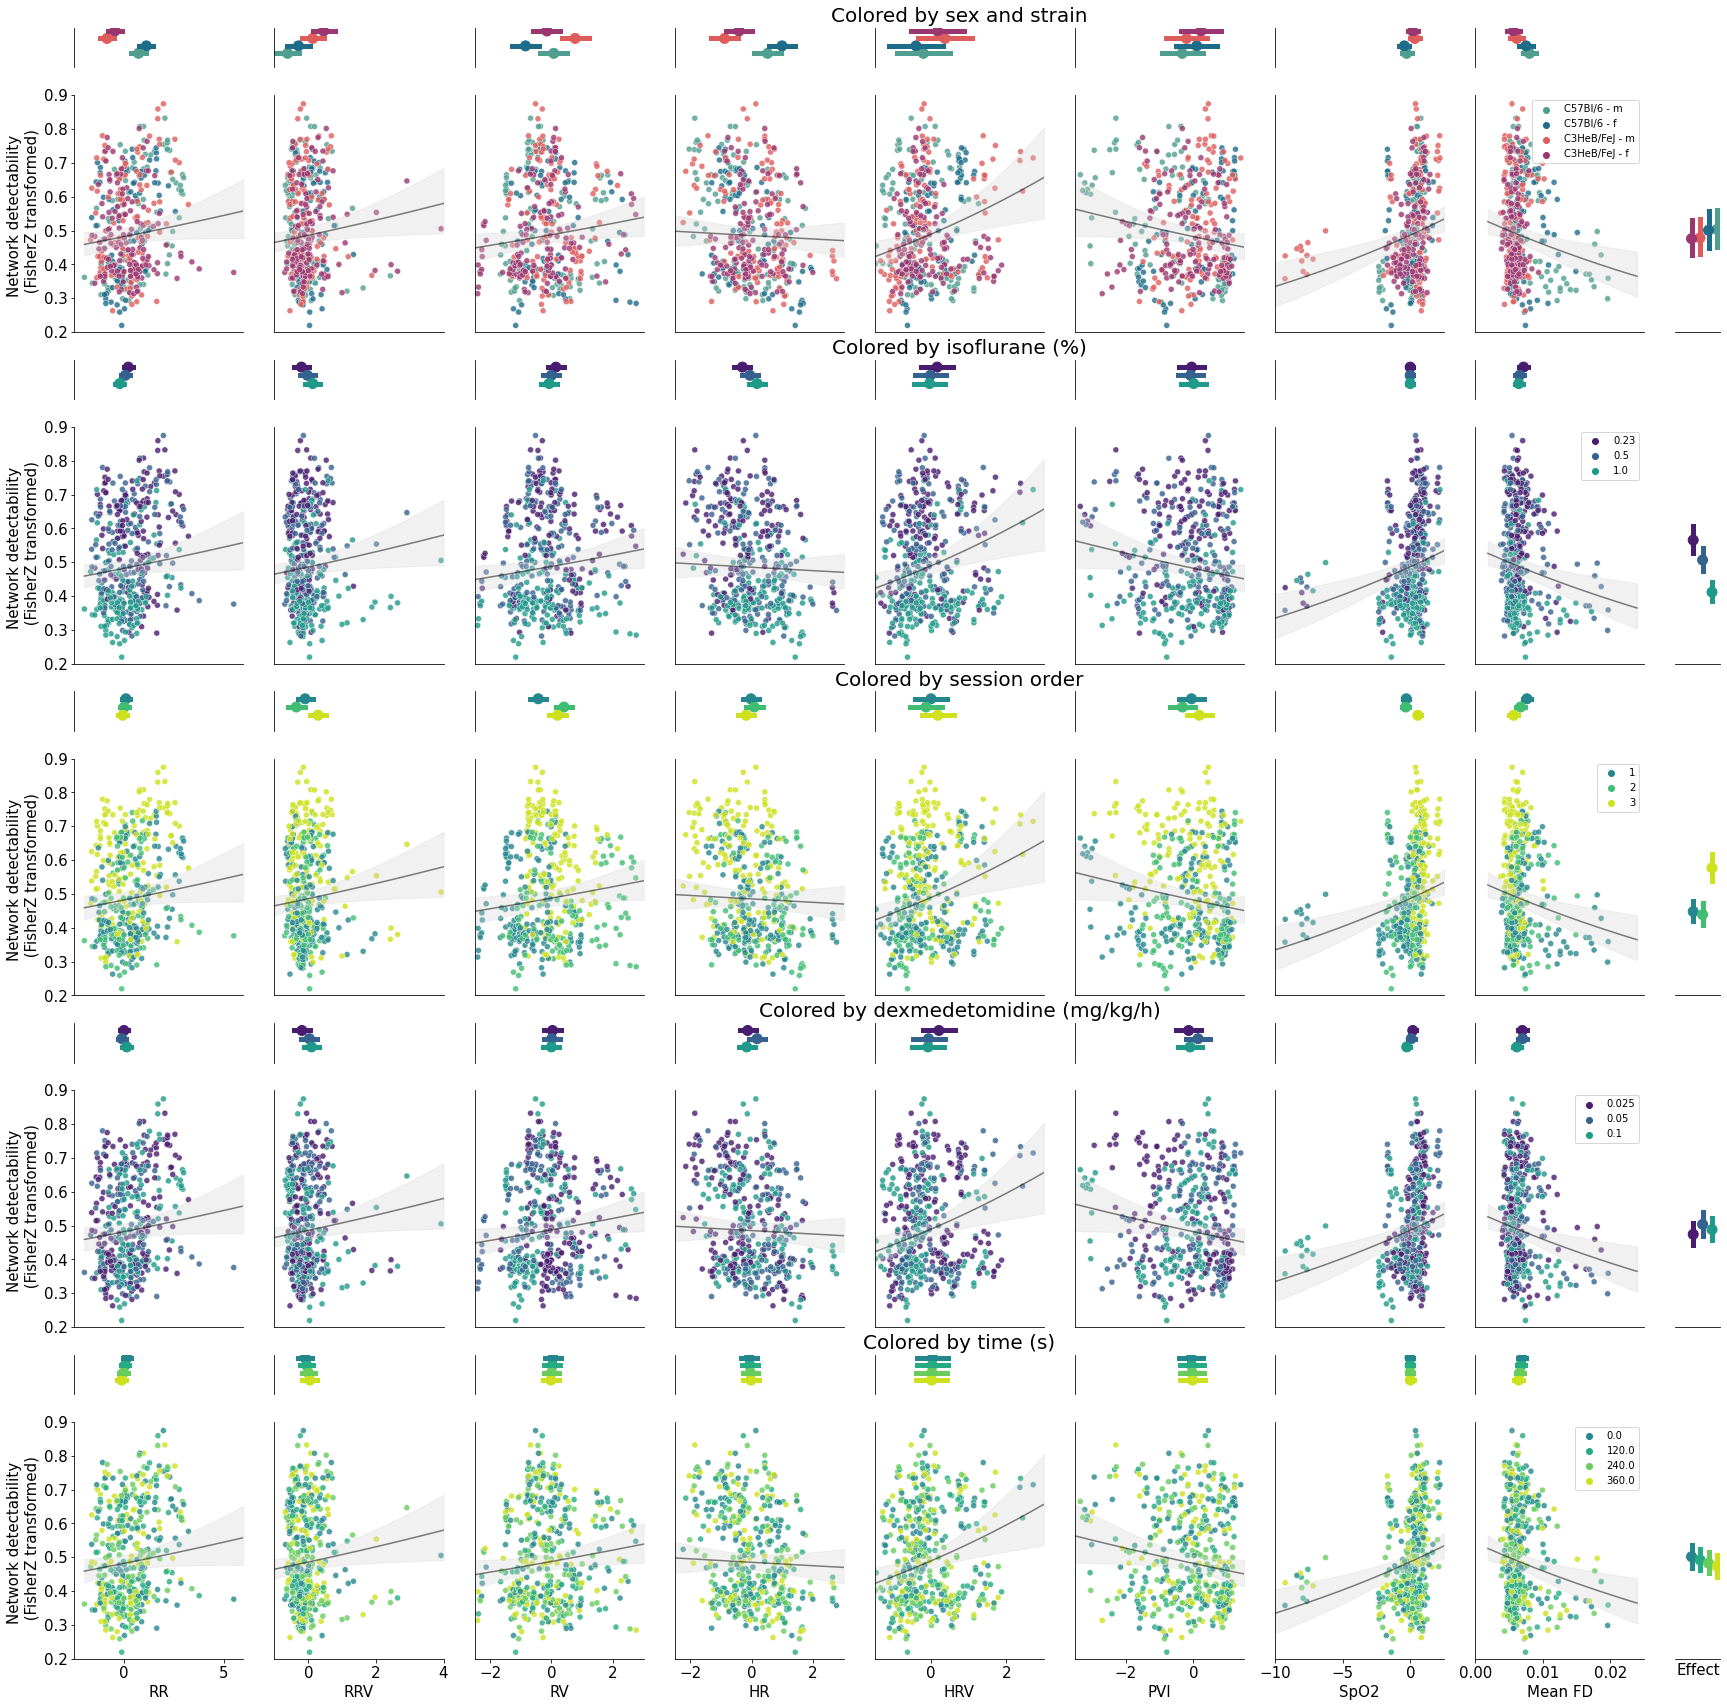

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

In [ ]:

df_full_renamed = df_full_renamed.assign(strain_sex=df_full_renamed['strain'].astype(str) + " - "  + df_full_renamed['sex'].astype(str))
effects_df_nd_strain_sex = effects_df_nd_strain_sex.assign(strain_sex=effects_df_nd_strain_sex['strain'].astype(str) + " - "  + effects_df_nd_strain_sex['sex'].astype(str))
df_full_renamed_round = df_full_renamed.round({'weight': 1})
fs = 15
xval = ['RR-sexstrain_zscore- mean in window', 'RRV-sexstrain_zscore- mean in window', 'RV-sexstrain_zscore- mean in window',
       'HR-sexstrain_zscore- mean in window', 'HRV-sexstrain_zscore- mean in window', 'PVI-sexstrain_zscore- mean in window',
       'SpO2-sexstrain_zscore- mean in window', 'Mean FD- mean in window']
xlabel = ['RR', 'RRV', 'RV','HR', 'HRV', 'PVI','SpO2', 'Mean FD']
hue_var= ['strain_sex', 'isoflurane (%)', 'session order (collinear with age)', 'dexmedetomidine (mg/kg/h)', 'Time after isoflurane change']
hue_var_title = ['Colored by sex and strain', 'Colored by isoflurane (%)', 'Colored by session order', 'Colored by dexmedetomidine (mg/kg/h)', 'Colored by time (s)']
hue_var_informal= ['strain_sex', 'iso', 'ses', 'dex', 'time']
xval_lims = [[-2.5, 6],  [-1, 4], [-2.5, 3], [-2.5, 3], [-1.5, 3], [-3.5, 1.5], [-10, 2.5], [0, 0.025]]
row_index_scatterplot = [1,3,5, 7, 9]
effects_df_list = [effects_df_nd_strain_sex, effects_df_nd_iso, effects_df_nd_ses, effects_df_nd_dex, effects_df_nd_time]

palette1 = sns.color_palette("crest", 2)[:] + sns.color_palette("flare", 2)[:]
palette2 = [sns.color_palette("viridis", 12)[i] for i in [0,3,6]]
palette3 = [sns.color_palette("viridis", 12)[i] for i in [5,8,11]]
palette4 = [sns.color_palette("viridis", 12)[i] for i in [5,7,9,11]]
palettes = [palette1, palette2, palette3, palette2, palette4]
number_of_colors = [4, 3, 3, 3, 4]

fig, axs = plt.subplots(10,9, figsize = (3*9.5 + 1, 3*10), gridspec_kw={'width_ratios': [3]*8 + [0.8], 'height_ratios': [0.5,3]*5})
for i in range(0, 9):
     for j in range(0, len(hue_var)):
        
        if (i==4):
            axs[row_index_scatterplot[j]-1, i].set_title(hue_var_title[j], fontsize = 20)

        #### plot rows of pointplots
        if i<8:

            #find the right csv and rename columns
            effects_df_row = pd.read_csv('./patha_' + str(xlabel[i]) + '_' + str(hue_var_informal[j]) + '.csv').rename(columns={'isoflurane_percent': 'isoflurane (%)', 
                                                                                                                                'actual_ses_order': 'session order (collinear with age)',
                                                                                                                                'Time.after.isoflurane.change': 'Time after isoflurane change',
                                                                                                                                'dex_conc' : 'dexmedetomidine (mg/kg/h)'})
            if hue_var[j] == 'strain_sex':
                effects_df_row = effects_df_row.assign(strain_sex=effects_df_row['strain'].astype(str) + " - "  + effects_df_row['sex'].astype(str))
                effects_df_row = effects_df_row.reindex([0,2,1,3]).reset_index()

            #compute mean and std of phgy var, add it back to the standardized fit, where necessary (ie for FD)
            if xval[i] == 'Mean FD- mean in window':
                phgy_mean = np.mean(df_full_renamed[xval[i]])
                phgy_std = np.std(df_full_renamed[xval[i]])
            else:
                phgy_mean = 0
                phgy_std = 1

            custom_pointplot(effects_df_row[hue_var[j]], y_values = effects_df_row['fit']*phgy_std + phgy_mean, error_upper = effects_df_row['upper']*phgy_std + phgy_mean, error_lower=effects_df_row['lower']*phgy_std + phgy_mean,
                                                        figsize = (3,5), ax = axs[row_index_scatterplot[j]-1, i], palette = palettes[j], orient = 'vertical', ylims = xval_lims[i])
            
            #### plot rows scatterplots
            plotting_parameters = {
                'data':    df_full_renamed_round,
                'x':       xval[i],
                'y':       "Network detectability \n (FisherZ transformed)",
                'hue':     hue_var[j],
                'palette':  palettes[j],
                'ax':       axs[row_index_scatterplot[j], i],
                'alpha':    0.8
            }
            axs[row_index_scatterplot[j], i].spines['right'].set_visible(False)
            axs[row_index_scatterplot[j], i].spines['top'].set_visible(False)
            axs[row_index_scatterplot[j], i].set_ylim([0.2, 0.9])
            axs[row_index_scatterplot[j], i].set_xlim(xval_lims[i])
            
            if j<4:
                axs[row_index_scatterplot[j], i].set_xlabel('')
                axs[row_index_scatterplot[j], i].set_xticks([])
            else:
                axs[row_index_scatterplot[j], i].set_xlabel(xlabel[i])
            if i<7:
                fig = sns.scatterplot(**plotting_parameters, legend= False)
            else:
                fig = sns.scatterplot(**plotting_parameters, legend= True)
                axs[row_index_scatterplot[j], i].legend(bbox_to_anchor=(1.7, 1), loc='upper left', borderaxespad=0, prop={'size': 40})
            if i>0:
                axs[row_index_scatterplot[j], i].set_ylabel('')
                axs[row_index_scatterplot[j], i].set_yticks([])
            
            ###plot physiology-network detectability curves
            if xlabel[i] == 'Mean FD':
                ending = '.csv'
            else:
                ending = '_sexstrain.csv'
            effects_phgy_nd_line = pd.read_csv('./pathb_nd_' + str(xlabel[i]) + ending).rename(columns = {'RR.sexstrain_zscore..mean.in.window': 'RR-sexstrain_zscore- mean in window', 'RRV.sexstrain_zscore..mean.in.window': 'RRV-sexstrain_zscore- mean in window', 'RV.sexstrain_zscore..mean.in.window': 'RV-sexstrain_zscore- mean in window',
                                                                                                    'HR.sexstrain_zscore..mean.in.window': 'HR-sexstrain_zscore- mean in window', 'HRV.sexstrain_zscore..mean.in.window': 'HRV-sexstrain_zscore- mean in window', 'PVI.sexstrain_zscore..mean.in.window': 'PVI-sexstrain_zscore- mean in window',
                                                                                                    'SpO2.sexstrain_zscore..mean.in.window': 'SpO2-sexstrain_zscore- mean in window', 'Mean.FD..mean.in.window': 'Mean FD- mean in window'})
            sns.lineplot(x = effects_phgy_nd_line[xval[i]]*phgy_std + phgy_mean, y = np.exp(effects_phgy_nd_line['fit']), ax = axs[row_index_scatterplot[j], i], color = 'black', alpha = 0.5)
            axs[row_index_scatterplot[j], i].fill_between(x = effects_phgy_nd_line[xval[i]]*phgy_std + phgy_mean, y1 = np.exp(effects_phgy_nd_line['lower']), y2 = np.exp(effects_phgy_nd_line['upper']), 
                                                          where = np.exp(effects_phgy_nd_line['upper']) > np.exp(effects_phgy_nd_line['lower']), color = 'lightgray', alpha = 0.3)
         
            
        ###plot pointplots along column at the end of each row of scatterplots
        else:
            effects_df = effects_df_list[j]

            if hue_var[j] == 'strain_sex':
                effects_df = effects_df.reindex([0,2,1,3]).reset_index()
            if j ==4:
                xlabel = 'Effect'
            else:
                xlabel = None
            axs[row_index_scatterplot[j], i] = custom_pointplot(effects_df[hue_var[j]], y_values = np.exp(effects_df['fit']), error_upper = np.exp(effects_df['upper']), error_lower=np.exp(effects_df['lower']),
                                            figsize = (3,5), ax = axs[row_index_scatterplot[j], i], xlabel=xlabel, palette = palettes[j], ylims=[0.2,0.9])
            axs[row_index_scatterplot[j]-1, i].axis('off')
plt.tight_layout()
plt.close()

fig.figure.savefig('./mediation_scatter_point_plots_transparent_sexstrainZscored_new.svg', transparent=True)
fig.figure.savefig('./final_plots_paper_mediation/mediation_scatter_point_plots_transparent_sexstrainZscored_new.png', transparent=True)

## Not sexstrain zscored phgy

RR- mean in window mean: 100.59638348773974 std: 22.367144146910878
RR- mean in window mean: 100.59638348773974 std: 22.367144146910878
RR- mean in window mean: 100.59638348773974 std: 22.367144146910878
RR- mean in window mean: 100.59638348773974 std: 22.367144146910878
RRV- mean in window mean: 0.03649217325082579 std: 0.025763322831466883
RRV- mean in window mean: 0.03649217325082579 std: 0.025763322831466883
RRV- mean in window mean: 0.03649217325082579 std: 0.025763322831466883
RRV- mean in window mean: 0.03649217325082579 std: 0.025763322831466883
RV- mean in window mean: 6.664869032947301 std: 3.5555194363516756
RV- mean in window mean: 6.664869032947301 std: 3.5555194363516756
RV- mean in window mean: 6.664869032947301 std: 3.5555194363516756
RV- mean in window mean: 6.664869032947301 std: 3.5555194363516756
HR- mean in window mean: 253.04868074363878 std: 44.58061368875606
HR- mean in window mean: 253.04868074363878 std: 44.58061368875606
HR- mean in window mean: 253.048680743

/tmp/user/1182/ipykernel_203772/4074290553.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


SpO2- mean in window mean: 86.1206957650122 std: 9.570493954255465
SpO2- mean in window mean: 86.1206957650122 std: 9.570493954255465
SpO2- mean in window mean: 86.1206957650122 std: 9.570493954255465
SpO2- mean in window mean: 86.1206957650122 std: 9.570493954255465
Mean FD- mean in window mean: 0.0067650744508523505 std: 0.002450485830509643
Mean FD- mean in window mean: 0.0067650744508523505 std: 0.002450485830509643
Mean FD- mean in window mean: 0.0067650744508523505 std: 0.002450485830509643
Mean FD- mean in window mean: 0.0067650744508523505 std: 0.002450485830509643


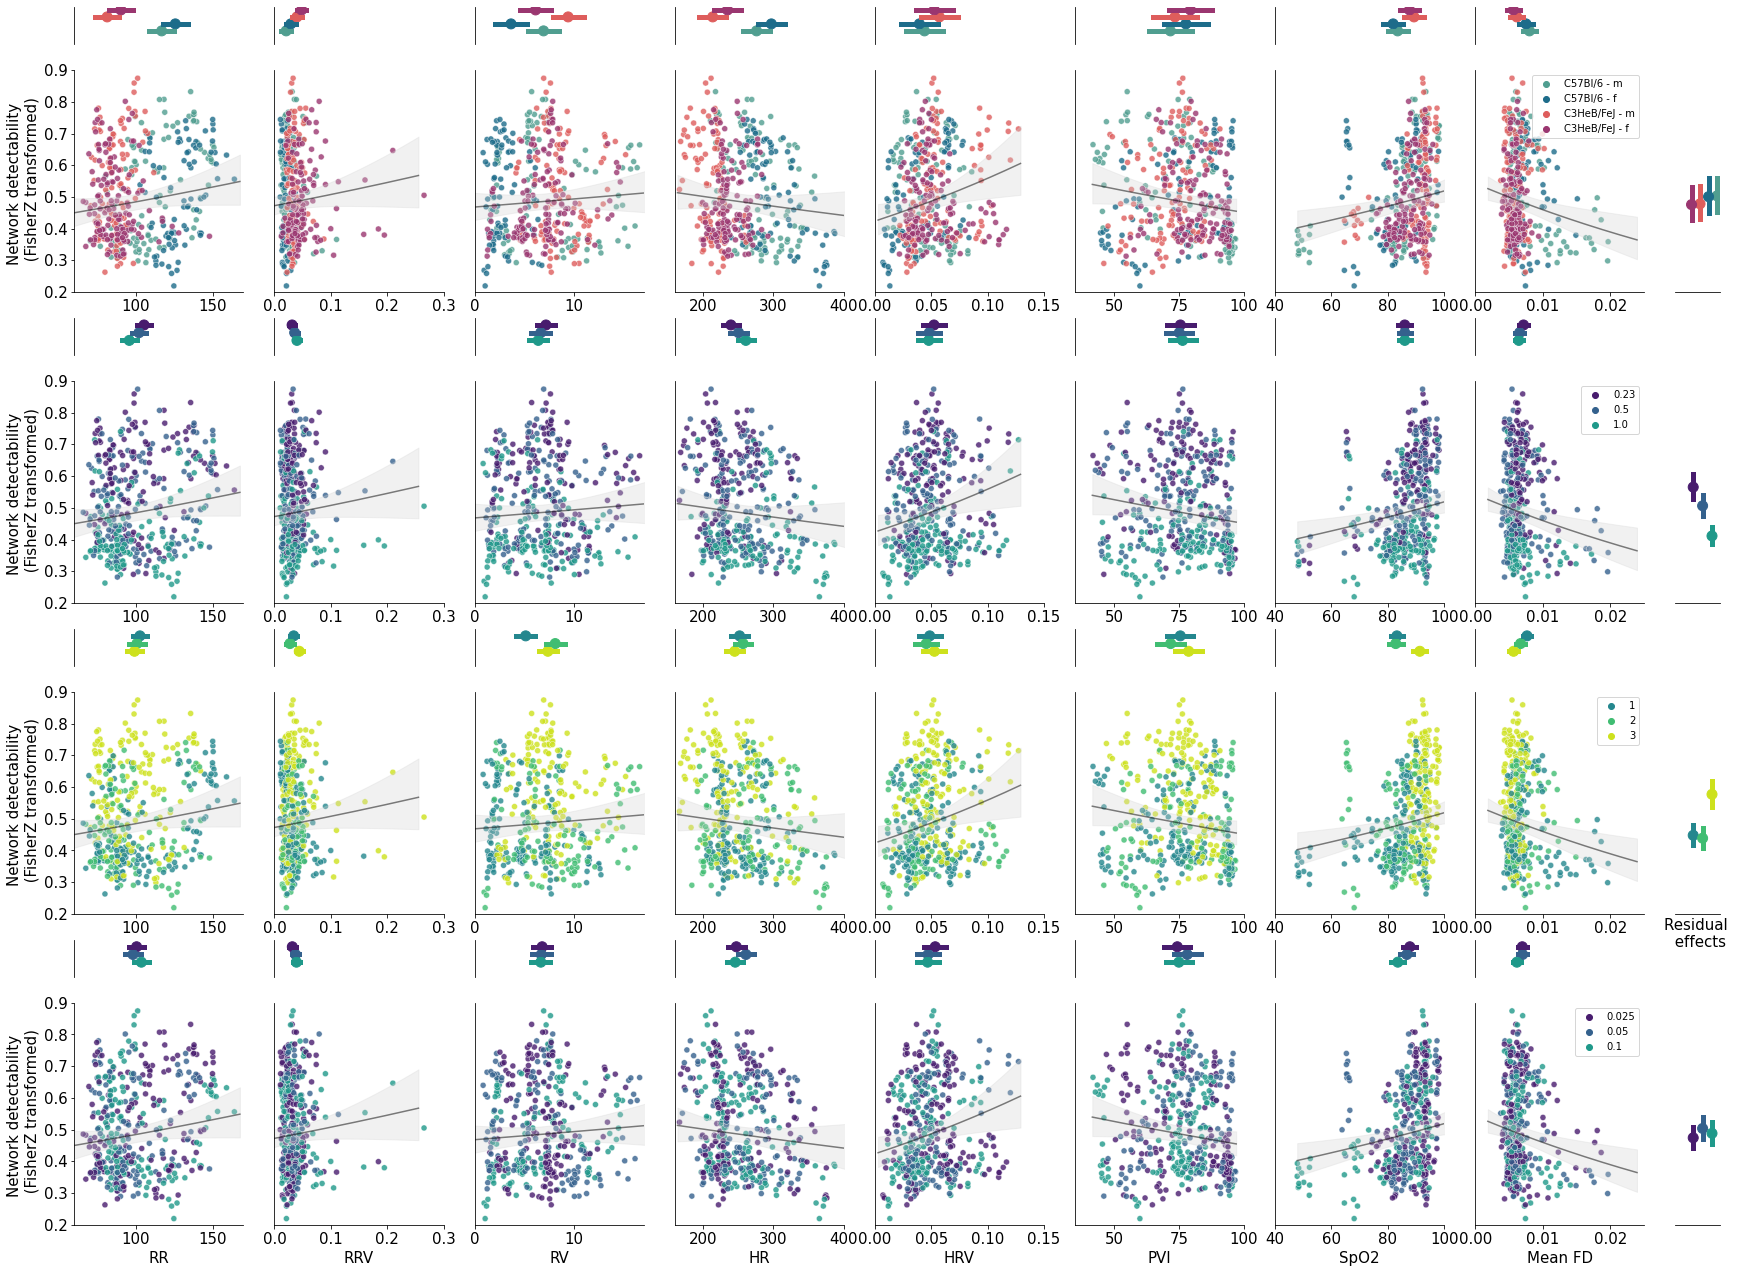

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

<Figure size 216x360 with 0 Axes>

In [ ]:

df_full_renamed = df_full_renamed.assign(strain_sex=df_full_renamed['strain'].astype(str) + " - "  + df_full_renamed['sex'].astype(str))
effects_df_nd_strain_sex = effects_df_nd_strain_sex.assign(strain_sex=effects_df_nd_strain_sex['strain'].astype(str) + " - "  + effects_df_nd_strain_sex['sex'].astype(str))
df_full_renamed_round = df_full_renamed.round({'weight': 1})
fs = 15
xval = ['RR- mean in window', 'RRV- mean in window', 'RV- mean in window',
       'HR- mean in window', 'HRV- mean in window', 'PVI- mean in window',
       'SpO2- mean in window', 'Mean FD- mean in window']
xlabel = ['RR', 'RRV', 'RV','HR', 'HRV', 'PVI','SpO2', 'Mean FD']
hue_var= ['strain_sex', 'isoflurane (%)', 'session order (collinear with age)', 'dexmedetomidine (mg/kg/h)']
hue_var_title = ['Colored by sex and strain', 'Colored by isoflurane (%)', 'Colored by session order', 'Colored by dexmedetomidine']
hue_var_informal= ['strain_sex', 'iso', 'ses', 'dex']
xval_lims = [[60, 170], [0, 0.3], [0, 17], [160, 400], [0, 0.15], [35, 100], [40, 100], [0, 0.025]]
row_index_scatterplot = [1,3,5, 7]
effects_df_list = [effects_df_nd_strain_sex, effects_df_nd_iso, effects_df_nd_ses, effects_df_nd_dex]

palette1 = sns.color_palette("crest", 2)[:] + sns.color_palette("flare", 2)[:]
palette2 = [sns.color_palette("viridis", 12)[i] for i in [0,3,6]]
palette3 = [sns.color_palette("viridis", 12)[i] for i in [5,8,11]]
palettes = [palette1, palette2, palette3, palette2]
number_of_colors = [4, 3, 3, 3]
cmap_bool = [False, False, False, False]

fig, axs = plt.subplots(8,9, figsize = (3*9.5 + 1, 2.8*8), gridspec_kw={'width_ratios': [3]*8 + [0.8], 'height_ratios': [0.5,3]*4})
for i in range(0, 9):
     for j in range(0, len(hue_var)):
        

        #### plot rows of pointplots
        if i<8:

            #find the right csv and rename columns
            effects_df_row = pd.read_csv('./patha_' + str(xlabel[i]) + '_' + str(hue_var_informal[j]) + '.csv').rename(columns={'isoflurane_percent': 'isoflurane (%)', 
                                                                                                                                'actual_ses_order': 'session order (collinear with age)',
                                                                                                                                'Time.after.isoflurane.change': 'Time after isoflurane change',
                                                                                                                                'dex_conc' : 'dexmedetomidine (mg/kg/h)'})
            if hue_var[j] == 'strain_sex':
                effects_df_row = effects_df_row.assign(strain_sex=effects_df_row['strain'].astype(str) + " - "  + effects_df_row['sex'].astype(str))
                effects_df_row = effects_df_row.reindex([0,2,1,3]).reset_index()
            #compute mean and std of phgy var, add it back to the standardized fit
            phgy_mean = np.mean(df_full_renamed[xval[i]])
            phgy_std = np.std(df_full_renamed[xval[i]])
            print(str(xval[i]) + ' mean: ' + str(phgy_mean) + ' std: ' + str(phgy_std))

            custom_pointplot(effects_df_row[hue_var[j]], y_values = effects_df_row['fit']*phgy_std + phgy_mean, error_upper = effects_df_row['upper']*phgy_std + phgy_mean, error_lower=effects_df_row['lower']*phgy_std + phgy_mean,
                                             figsize = (3,5), ax = axs[row_index_scatterplot[j]-1, i], palette = palettes[j], orient = 'vertical', ylims = xval_lims[i])
            
            #### plot rows scatterplots
            plotting_parameters = {
                'data':    df_full_renamed_round,
                'x':       xval[i],
                'y':       "Network detectability \n (FisherZ transformed)",
                'hue':     hue_var[j],
                'palette':  palettes[j],
                'ax':       axs[row_index_scatterplot[j], i],
                'alpha':    0.8
            }
            axs[row_index_scatterplot[j], i].spines['right'].set_visible(False)
            axs[row_index_scatterplot[j], i].spines['top'].set_visible(False)
            axs[row_index_scatterplot[j], i].set_ylim([0.2, 0.9])
            axs[row_index_scatterplot[j], i].set_xlim(xval_lims[i])
            
            axs[row_index_scatterplot[j], i].set_xlabel(xlabel[i])
            if i<7:
                fig = sns.scatterplot(**plotting_parameters, legend= False)
            else:
                fig = sns.scatterplot(**plotting_parameters, legend= True)
                axs[row_index_scatterplot[j], i].legend(bbox_to_anchor=(1.7, 1), loc='upper left', borderaxespad=0, fontsize = 'x-large')
            if i>0:
                axs[row_index_scatterplot[j], i].set_ylabel('')
                axs[row_index_scatterplot[j], i].set_yticks([])
            
            ###plot physiology-network detectability curves
            effects_phgy_nd_line = pd.read_csv('./pathb_nd_' + str(xlabel[i]) + '.csv').rename(columns = {'RR..mean.in.window': 'RR- mean in window', 'RRV..mean.in.window': 'RRV- mean in window', 'RV..mean.in.window': 'RV- mean in window',
                                                                                                    'HR..mean.in.window': 'HR- mean in window', 'HRV..mean.in.window': 'HRV- mean in window', 'PVI..mean.in.window': 'PVI- mean in window',
                                                                                                    'SpO2..mean.in.window': 'SpO2- mean in window', 'Mean.FD..mean.in.window': 'Mean FD- mean in window'})
            sns.lineplot(x = effects_phgy_nd_line[xval[i]]*phgy_std + phgy_mean, y = np.exp(effects_phgy_nd_line['fit']), ax = axs[row_index_scatterplot[j], i], color = 'black', alpha = 0.5)
            axs[row_index_scatterplot[j], i].fill_between(x = effects_phgy_nd_line[xval[i]]*phgy_std + phgy_mean, y1 = np.exp(effects_phgy_nd_line['lower']), y2 = np.exp(effects_phgy_nd_line['upper']), 
                                                          where = np.exp(effects_phgy_nd_line['upper']) > np.exp(effects_phgy_nd_line['lower']), color = 'lightgray', alpha = 0.3)
            
            
        ###plot pointplots along column at the end of each row of scatterplots
        else:
            effects_df = effects_df_list[j]

            if hue_var[j] == 'strain_sex':
                effects_df = effects_df.reindex([0,2,1,3]).reset_index()
            if j ==2:
                xlabel = 'Residual \n effects'
            else:
                xlabel = None
            axs[row_index_scatterplot[j], i] = custom_pointplot(effects_df[hue_var[j]], y_values = np.exp(effects_df['fit']), error_upper = np.exp(effects_df['upper']), error_lower=np.exp(effects_df['lower']),
                                            figsize = (3,5), ax = axs[row_index_scatterplot[j], i], xlabel=xlabel, palette = palettes[j], ylims=[0.2,0.9])
            axs[row_index_scatterplot[j]-1, i].axis('off')
plt.tight_layout()
plt.close()

fig.figure.savefig('./final_plots_paper_mediation/mediation_scatter_point_plots_transparent.svg', transparent=True)
fig.figure.savefig('./final_plots_paper_mediation/mediation_scatter_point_plots_transparent.png', transparent=True)

### Represent the sex:dex interactions using swarm plots

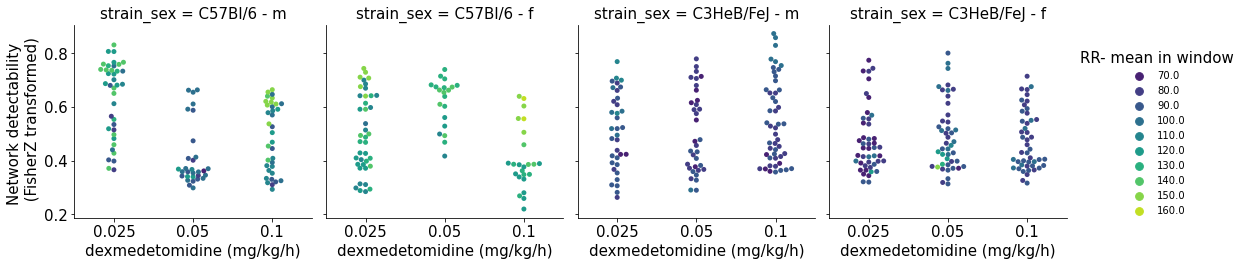

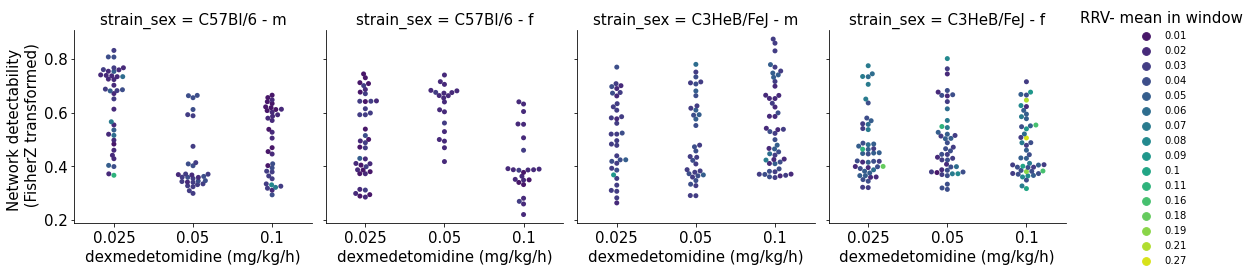

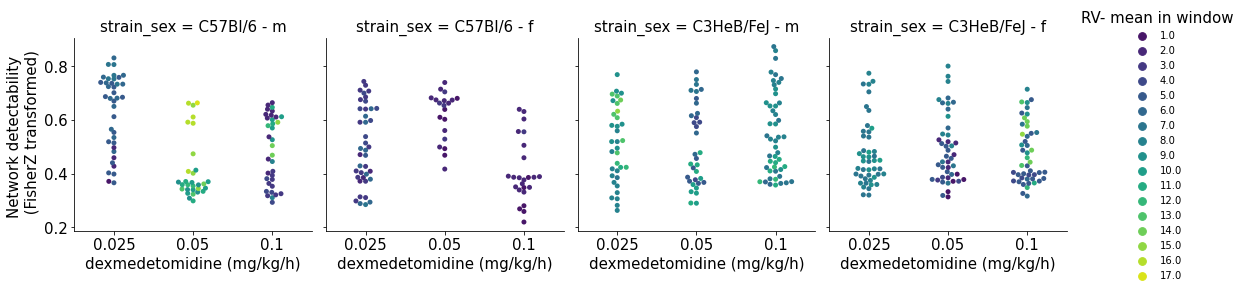

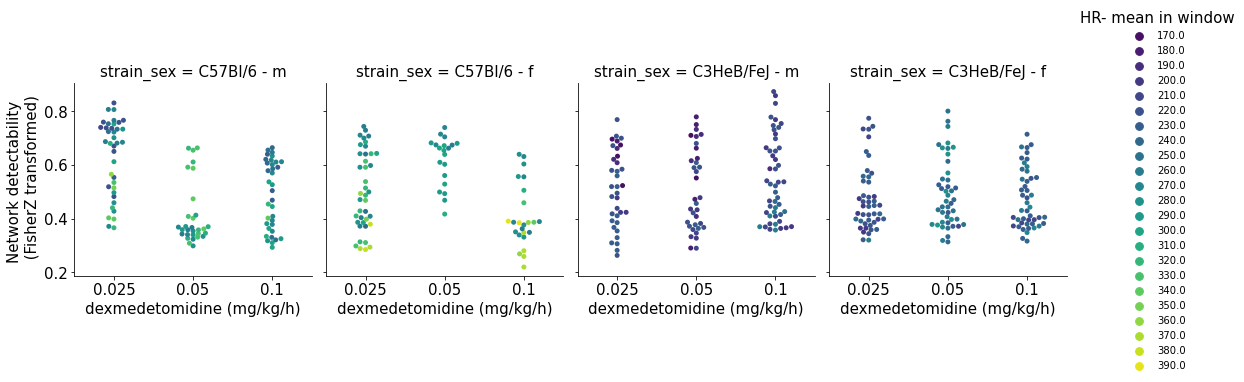

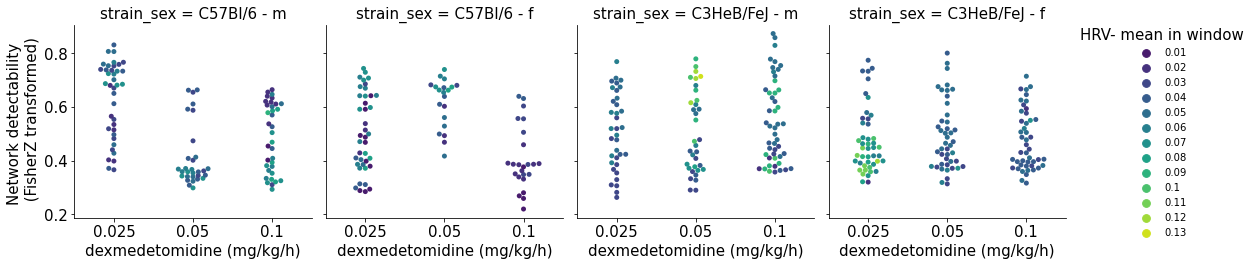

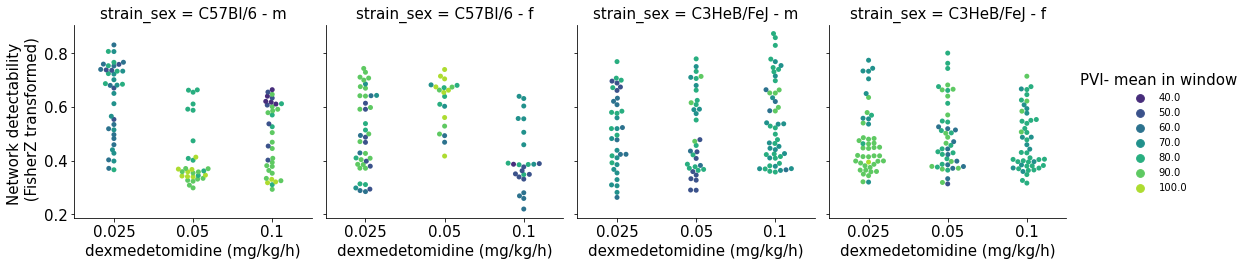

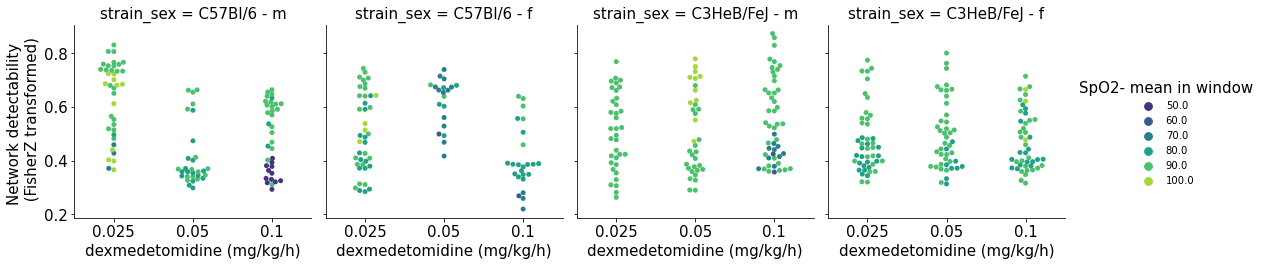

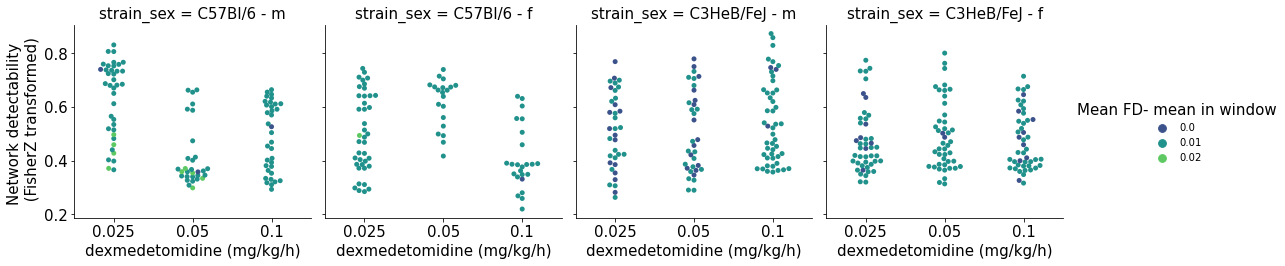

In [ ]:
df_full_renamed = df_full_renamed.assign(strain_sex=df_full_renamed['strain'].astype(str) + " - " + df_full_renamed['sex'].astype(str).astype(str))
xval_rounding = [-1, 2, 0, -1, 2, -1, -1, 2]

for i in range(0, len(xval)):
    df_full_renamed_round = df_full_renamed.round({xval[i]: xval_rounding[i]})
    fig = sns.catplot(data=df_full_renamed_round, x="dexmedetomidine (mg/kg/h)", y='Network detectability \n (FisherZ transformed)', col='strain_sex', 
                kind="swarm", hue=xval[i], height= 3.8, aspect = 1, palette= 'viridis')
    fig.figure.savefig('./final_plots_paper_mediation/interaction_swarm_plot_dex-sexstrain_colored-' + str(xval[i]) + '.png', transparent=True)

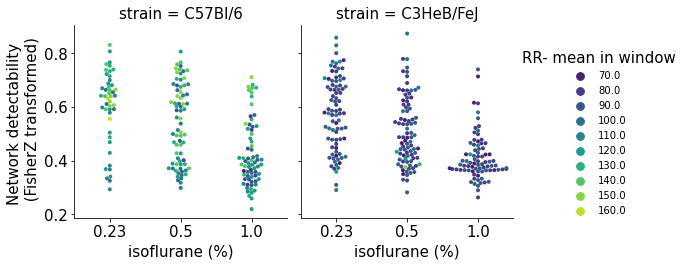

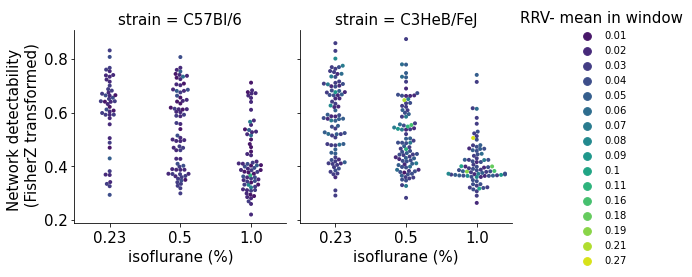

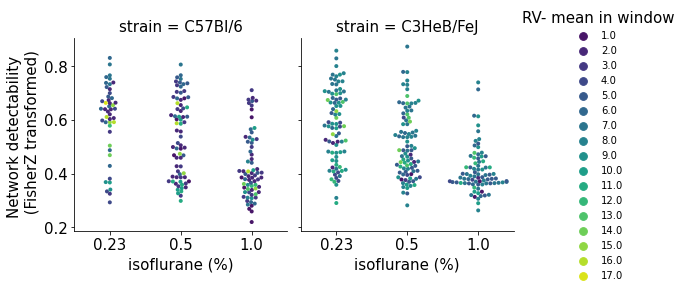

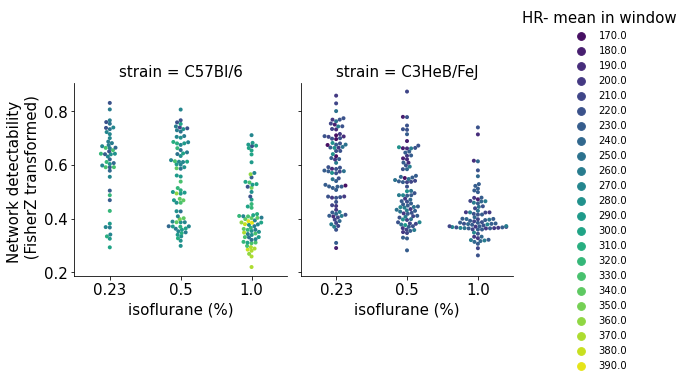

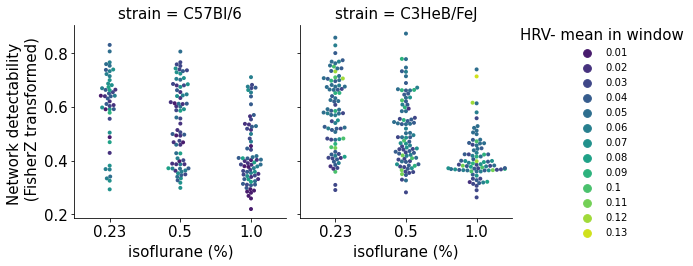

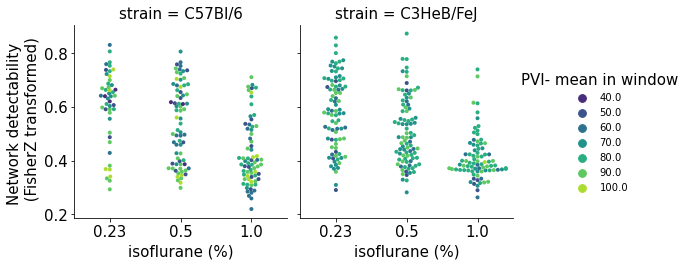

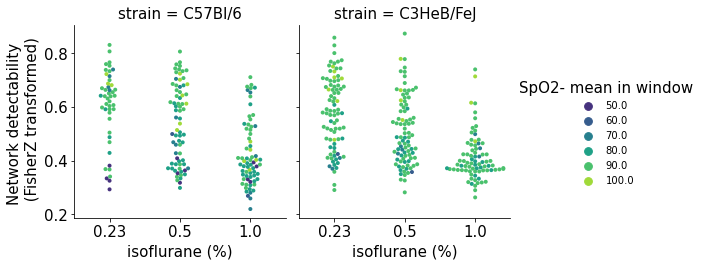

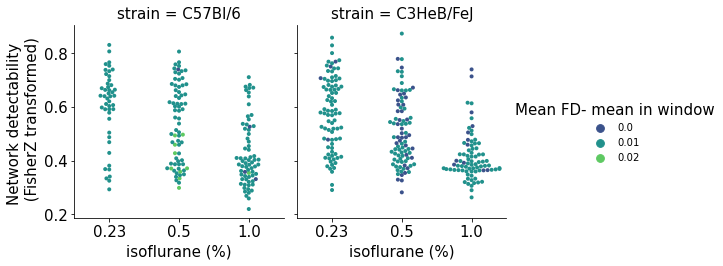

In [ ]:
df_full_renamed = df_full_renamed.assign(strain_sex=df_full_renamed['strain'].astype(str) + " - " + df_full_renamed['sex'].astype(str).astype(str))
xval_rounding = [-1, 2, 0, -1, 2, -1, -1, 2]

for i in range(0, len(xval)):
    df_full_renamed_round = df_full_renamed.round({xval[i]: xval_rounding[i]})
    fig = sns.catplot(data=df_full_renamed_round, x="isoflurane (%)", y='Network detectability \n (FisherZ transformed)', col='strain', s = 4,
                kind="swarm", hue=xval[i], height= 3.8, aspect = 1, palette= 'viridis')
    fig.figure.savefig('./final_plots_paper_mediation/interaction_swarm_plot_iso-strain_colored-' + str(xval[i]) + '.png', transparent=True)